# Introduction

This cell downloads the data as needed when not on Kaggle.

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

We'll be using numpy and pytorch for array calculations in this notebook, and pandas for working with tabular data, so we'll import them and set them to display using a bit more space than they default to.

In [19]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# Cleaning the data

In [11]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# the number of nans in each column
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
# the mode value of each column 
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                         0
Pclass                           3
Name           Abbing, Mr. Anthony
Sex                           male
Age                             24
SibSp                            0
Parch                            0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [15]:
#use fillna to replace the missing values with the mode of each column 
#doing it "in place" -- meaning that we'll change the dataframe itself, 
#rather than returning a new one
df.fillna(modes, inplace=True)

# check that the nans are now removed
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [16]:
# quick summary of all the numeric columns in the datase
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


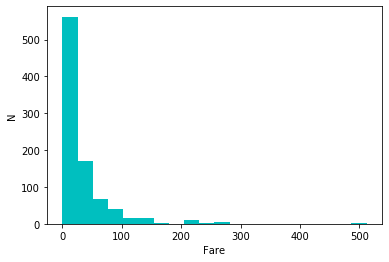

In [25]:
# histogram of the fares paid by the passengers - notice the long tail
% matplotlib inline
plt.hist(df['Fare'], bins = 20, color = 'c')
plt.xlabel('Fare')
plt.ylabel('N')
plt.show()

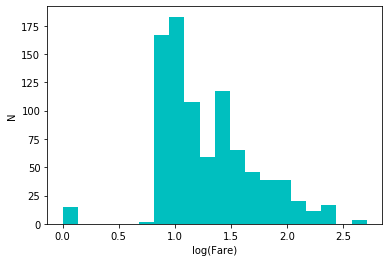

In [27]:
# take logrithm of Fare values to "squish" it so that the outliars don't dominate future calculations
df['LogFare'] = np.log10(df['Fare']+1) # add 1 becuase Fare contains zeros

# plot histogram of logged values
plt.hist(df['LogFare'], bins = 20, color = 'c')
plt.xlabel('log(Fare)')
plt.ylabel('N')
plt.show()

In [34]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [35]:
# quick summary of all the non-numeric columns columns in the datase
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",male,CA. 2343,B96 B98,S
freq,1,577,7,691,646


In [37]:
# create new columns containing dummy variables for string columns with reasonable # of unique values
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [43]:
from torch import tensor

# set the dependent variable, Survived, as a tensor
t_dep = tensor(df.Survived)

# set the independent continous variables as tensors
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype = torch.float)

# the number of rows and columns we have for our independent variables
t_indep.shape

torch.Size([891, 12])

# Setting up a linear model
